In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import exoplanet as xo
import pymc3 as pm
from astropy.constants import R_sun, M_sun, R_earth, M_earth
from astropy import units as u

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
%matplotlib notebook

#%matplotlib inline

In [8]:
def bjd2bkjd(bjd):
    
    return bjd - 2454833.0


def bkjd2bjd(bkjd):
    
    return bkjd + 2454833.0


def get_orbit(t, p, k, tc, e, w, gamma=0.0):
    
    #print(p, k, tc, e, w, gamma)
    
    from radvel import Parameter, Parameters, RVModel
    
    synth_params = Parameters(1, basis='per tc e w k')
    synth_params['per1'] = Parameter(value = p)
    synth_params['tc1'] = Parameter(value = tc)
    synth_params['e1'] = Parameter(value = e)
    synth_params['w1'] = Parameter(value = w)
    synth_params['k1'] = Parameter(value = k)

    synth_params['gamma'] = Parameter(value=0.0)
    synth_params['dvdt'] = Parameter(value=0.0)
    synth_params['curv'] = Parameter(value=0.0)

    synth_model = RVModel(params=synth_params)
    
    return synth_model(t) + gamma


def u_to_uaub(x):
    q = np.array([x ** 2, 0.5 * x / x])
    return np.log(q) - np.log(1 - q)


def b_to_incl(b, a, R1):
    # b = a * cos(i) / R1
    return np.arccos(b / a * R1)


def mk_dist(var, params):
    
    if np.any(var == shape_1_vars):

        #print(var, 'making shape = 1')

        test_val = np.array([params['sv'][var]])
        shape = 1

    else:

        test_val = params['sv'][var]
        shape = 1

    if params['toggle'][var]:

        if params['dist'][var] == 'normal':

            var_dist = pm.Normal(var, 
                                 mu=params['sv'][var], 
                                 sd=params['sd'][var], 
                                 shape=shape, 
                                 testval=test_val)

        elif params['dist'][var] == 'uniform':

            var_dist = pm.Uniform(var, 
                                  lower=params['lb'][var], 
                                  upper=params['ub'][var], 
                                  shape=shape, 
                                  testval=test_val)

        else:

            print('ERROR: You didnt pick a valid distribution for ' + var + '. You chose "' + params['dist'][var] + '"')

            return None


    else:
        var_dist = test_val

    return var_dist


def make_lc_rv_mcmc(data, params, optimize_q=True):
    
    # Need:
    # * period   # The orbital periods of the bodies in days
    # * m_star   # The mass of the star in M_sun
    # * incl (or b)    # The inclinations of the orbits in radians
    # * b        # impact param (made from radius ratio)      
    # * ecc
    # * omega    # The arguments of periastron for the orbits in radians
    # * R1   # The radius of the star in R_sun
    # * t0       # The time of a reference transit for each orbits in days
    
    
    # Docs: https://docs.exoplanet.codes/en/stable/user/api/
    
    
    import pymc3 as pm
    import pymc3_ext as pmx
    from celerite2.theano import terms, GaussianProcess
    import theano.tensor as tt

    with pm.Model() as model:
        
        ############################################################################
        # Systemic parameters   
        
        cont = mk_dist('cont', params) # The baseline flux
        
        t0 = mk_dist('t0', params) # The time of a reference transit for each planet
        
        p = mk_dist('p', params) 
        
        rr = mk_dist('r_ratio', params) 
        
        M2 = None
            
        #############################################
            
        u1a = mk_dist('u1a', params) 
        
        u1b = mk_dist('u1b', params) 
        
        if params['toggle']['u1a'] and params['toggle']['u1b']:
            
            u1 = pm.math.concatenate([u1a, u1b])
            
        else:
            
            u1 = np.array([u1a, u1b])
            
        #############################################
        
        if params['toggle']['ecc_is_zero']:
            
            ecc = None

            omega = None
        
        else:
            
            ecc = mk_dist('ecc', params)

            omega = mk_dist('omega', params)
        
        #############################################
        
        if params['toggle']['has_sec_eclipse']:
            
            u2a = mk_dist('u2a', params) 

            u2b = mk_dist('u2b', params) 
        
            s = mk_dist('s', params) # surface brightness ratio
            
            if params['toggle']['u2a'] and params['toggle']['u2b']:
            
                u2 = pm.math.concatenate([u2a, u2b])

            else:

                u2 = np.array([u2a, u2b])
        
        #############################################
        
        if params['toggle']['use_a']:
            
            a = mk_dist('a', params) 
            
            M1 = None
            
        else:
            
            M1 = mk_dist('M1', params)
            
        #############################################
        
        if params['toggle']['use_b']:
            
            b = mk_dist('b', params) 
            
            incl = None
            
        else:
            
            incl = mk_dist('incl', params)
            
            b = None
          
        #############################################
        
        R1 = mk_dist('R1', params) 
        
        if params['toggle']['R1'] or params['toggle']['r_ratio']:
            
            R2 = pm.Deterministic("R2", rr * R1)
            
        else:
            
            R2 = rr * R1
            
        
        ############################################################################
        # Set up a Keplerian orbit for the planets
        
        orbit = xo.orbits.KeplerianOrbit(period=p, 
                                         t0=t0, 
                                         a=a,
                                         b=b,
                                         incl=incl,
                                         ecc=ecc, 
                                         omega=omega,
                                         r_star=R1,
                                         m_star=M1,
                                         m_planet=M2,
                                        )
        
        
        ############################################################################
        # Monitor derived params
        
        if params['toggle']['use_b']:
            
            pm.Deterministic("incl", orbit.incl)
            
        else:
            
            pm.Deterministic("b", orbit.b)
            
            
        if not params['toggle']['use_a']:
            
            pm.Deterministic("a", orbit.a)
        
        
        ############################################################################
        # LC stuff
        
        if params['toggle']['has_sec_eclipse']:
            
#             print(u1)
#             print(u2)
#             print(s)
#             print(R2)
            
#             return u1, u2, s
            
            light_curves = xo.SecondaryEclipseLightCurve(u1, u2, s).get_light_curve(orbit=orbit, r=R2, t=data['lc_time'][transit_idx])

            light_curve = pm.math.sum(light_curves, axis=-1) + cont
            
        else:
            
            light_curves = xo.LimbDarkLightCurve(u1).get_light_curve(orbit=orbit, r=R2, t=data['lc_time'][transit_idx])

            light_curve = pm.math.sum(light_curves, axis=-1) + cont
        
        
        # In this line, we simulate the dataset that we will fit
        sim_lc = xo.eval_in_model(light_curve)
        
        
        # This is the part that actually does the model comparison to the real data to determine error
        if params['toggle']['lc_err']:
            
            lc_err = mk_dist('lc_err', params) 

            # The likelihood function assuming known Gaussian uncertainty
            pm.Normal('obs_lc', 
                      mu=light_curve, 
                      sd=lc_err,
                      observed=data['lc_flux'][transit_idx])
        
        else:
            
            # The likelihood function assuming known Gaussian uncertainty
            pm.Normal('obs_lc', 
                      mu=light_curve, 
                      sd=data['lc_flux_err'][transit_idx], 
                      observed=data['lc_flux'][transit_idx])

        
        # Save all LCs (required for easy plotting code)
        pm.Deterministic("light_curves", light_curves)
        
        
        ############################################################################
        # Optimize
        
        map_soln = model.test_point
        
        if optimize_q:

            # Optimize individual params

            if params['toggle']['t0']:
                map_soln = pmx.optimize(map_soln, [t0])
                
            if params['toggle']['incl'] and not params['toggle']['use_b']:
                map_soln = pmx.optimize(map_soln, [incl])

            if params['toggle']['ecc']:
                map_soln = pmx.optimize(map_soln, [ecc])

            if params['toggle']['omega']:
                map_soln = pmx.optimize(map_soln, [omega])

            if params['toggle']['r_ratio']:
                map_soln = pmx.optimize(map_soln, [rr])

            if params['toggle']['u1a'] and params['toggle']['u1b']:
                map_soln = pmx.optimize(map_soln, [u1a, u1b])

            if params['toggle']['u2a'] and params['toggle']['u2b']:
                map_soln = pmx.optimize(map_soln, [u2a, u2b])

            if params['toggle']['t0']:
                map_soln = pmx.optimize(map_soln, [t0])

            if params['toggle']['b'] and params['toggle']['s']:
                map_soln = pmx.optimize(map_soln, [b, s])

            if params['toggle']['incl'] and not params['toggle']['use_b']:
                map_soln = pmx.optimize(map_soln, [incl])

            if params['toggle']['u2a'] and params['toggle']['u2b']:
                map_soln = pmx.optimize(map_soln, [u2a, u2b])

            if params['toggle']['b'] and params['toggle']['s'] and params['toggle']['t0']:
                map_soln = pmx.optimize(map_soln, [b, s, t0])

            if params['toggle']['ecc']:
                map_soln = pmx.optimize(map_soln, [ecc])
            
            # Then optimize all params
            map_soln = pmx.optimize(map_soln)
            
    return model, map_soln, orbit, sim_lc


def get_phase(ecc, w, position):
    
    if position == "periastron": 
        TA = 0.0
    elif position == "primary": 
        TA = np.pi / 2.0 - w * np.pi / 180.0
    elif position == "secondary": 
        TA = 3.0 * np.pi / 2.0 - w * np.pi / 180.0

    E = 2.0 * np.arctan(np.sqrt( (1.0 - ecc) / (1.0 + ecc) ) * np.tan(TA / 2.0))
    
    M = E - ecc * np.sin(E)
    
    return M / 2.0 / np.pi

def get_t_periastron(per, t0, ecc, w):
    """
    Return the time of periastron passage (calculated using `params.t0`).
    """
    phase = get_phase(ecc, w, "primary")
    
    return t0 - per * phase

def get_t_secondary(per, t0, ecc, w):
    """
    Return the time of secondary eclipse center (calculated using `params.t0`).
    """
    phase = get_phase(ecc, w, "primary")
    phase2 = get_phase(ecc, w, "secondary")
    
    return t0 + per * (phase2 - phase)

def get_t_conjunction(self, params):
    """
    Return the time of primary transit center (calculated using `params.t_secondary`).
    """
    phase = get_phase(ecc, w, "primary")
    phase2 = get_phase(ecc, w, "secondary")
    
    return params.t_secondary + params.per * (phase - phase2)


def mask_transits(t0_bkjd, period_day, duration_day, time_bkjd, flux, 
                  lc=None, return_index=True):
   
    # http://www.raa-journal.org/docs/Supp/ms4253tab1.txt
       
    if lc != None:
        
        time_bkjd = np.array(lc.astropy_time.value)

        flux = lc.flux
   
    t0f_bkjd = np.copy(t0_bkjd)
      
    tots_bkjd = get_transit_times(t0f_bkjd, period_day, duration_day, time_bkjd, flux)
   
    # For each tranist find all datapoints within the tranist duration window
   
    ntot_idx = np.ones(len(flux), dtype=bool)
   
    for tot in tots_bkjd:
       
        tot_idx = (time_bkjd > tot - duration_day / 2) & (time_bkjd < tot + duration_day / 2)
       
        ntot_idx = ntot_idx & ~tot_idx
    
    if return_index:
        return ~ntot_idx # Returns where transits occur
    else:
        return time_bkjd[ntot_idx], flux[ntot_idx]
    
    
def get_transit_times(t0_bkjd, period_day, duration_day, time_bkjd, flux):
    
    t0f_bkjd = np.copy(t0_bkjd)
   
    while t0f_bkjd > time_bkjd[0]:
       
        t0f_bkjd -= period_day
        
    #t0f_bkjd += period_day
        
    while t0f_bkjd < time_bkjd[0]:
       
        t0f_bkjd += period_day
        
    #t0f_bkjd -= period_day
       
    return np.arange(t0f_bkjd, time_bkjd.max(), step=period_day)


def plot_fits(t0, p, fit):
    
    pfrac = 20
    
    #t0_sec_day = get_t_secondary(p, t0, ecc, omega)
    
    lc_t_fold = (data['lc_time'] - t0 + 0.5 * p) % p - 0.5 * p

    si_p_rfold = np.argsort(lc_t_fold[transit_idx])
    
    pt = lc_t_fold[transit_idx][si_p_rfold]
    pf =  data['lc_flux'][transit_idx][si_p_rfold]
    pff = fit[si_p_rfold]
    pgi = (pt > -p / pfrac) & (pt < p / pfrac)
    pdf = pf[pgi] - pff[pgi]

    spc = 2
    if has_sec_eclipse:
        
        lc_t_sec_fold = (data['lc_time'] - t0_sec_day + 0.5 * p) % p - 0.5 * p
        
        si_s_rfold = np.argsort(lc_t_sec_fold[transit_idx])

        st = lc_t_sec_fold[transit_idx][si_s_rfold]
        sf =  data['lc_flux'][transit_idx][si_s_rfold]
        sff = fit[si_s_rfold]
        sgi = (st > -p / pfrac) & (st < p / pfrac)
        sdf = sf[sgi] - sff[sgi]
        
        spc = 4
        
    
    plt.figure(figsize=(13,11))
    plt.subplot(spc,1,1)
    plt.title('Fit based on MLE values')
    plt.plot(pt[pgi], pf[pgi], '.k')
    plt.plot(pt[pgi], pff[pgi], '-r')

    plt.subplot(spc,1,2)
    plt.title('RMS = ' + str(np.around(np.std(pdf), 5)))
    plt.plot(pt[pgi], pdf, '.k')

    if has_sec_eclipse:
        plt.subplot(spc,1,3)
        plt.title('Secondary')
        plt.plot(st[sgi], sf[sgi], '.k')
        plt.plot(st[sgi], sff[sgi], '-', c=[0,1,0])

        plt.subplot(spc,1,4)
        plt.title('RMS = ' + str(np.around(np.std(sdf), 5)))
        plt.plot(st[sgi], sdf, '.k')


    plt.figure(figsize=(13,5))
    plt.plot(data['lc_time'], data['lc_flux'], '.k')
    plt.plot(data['lc_time'][transit_idx], fit, '-r')

# Provide several details about your target

* KIC
* t0
* period
* duration
* is an eclipsing binary and has a secondary elipse? (bool)

In [9]:
target_name, t0_pri_day, p_day, d_day, has_sec_eclipse, t0_sec_day = '8804845', 135.870397, 5.425838, 3.0/24, 0, None

# Load your LC data

You will need to edit this since its unlikely that you save your data like I did.

You need:
* time array
* flux array
* flux error array

In [10]:
if 0:
    lc_data_dir = opj('/media/rd1/kwillis/SB2_LC_RV_pipeline/v1/data/lc', plateName + '_' + str(beamNum_odd))
    # rv_data_dir = opj('./data/rv', plateName + '_' + str(beamNum_odd))

    lc_lf = np.load(opj(lc_data_dir, plateName + '_' + str(beamNum_odd) + '_LC_data.npz'))
    # rv_lf = np.load(opj(rv_data_dir, 'rv_and_param_data.npz'))
    
else:
    
    lc_data_dir = opj('/media/rd1/kwillis/SB2_LC_RV_pipeline/v1/data/lc', 'kic_' + target_name)
    
    lc_lf = np.load(opj(lc_data_dir, 'kic_' + target_name + '_LC_data.npz'))


kic = target_name


oe_idx = 0

data = {'lc_flux': lc_lf['flux_norm'], 
        'lc_flux_err': lc_lf['flux_err_norm'],
        'lc_time': lc_lf['time_norm'],
       }

if target_name == '11922782':
    
    if np.nanmean(data['lc_flux_err']) > 0.1:
        
        data['lc_flux_err'] = data['lc_flux_err'] / 1000

if data['lc_time'][0] > 1e3:
    
    data['lc_time'] = data['lc_time'] - 2454833.0
    
    
if t0_pri_day > 1e3:

    t0_pri_day = bjd2bkjd(t0_pri_day)
    
if has_sec_eclipse:
    
    if t0_sec_day > 1e3:

        t0_sec_day = bjd2bkjd(t0_sec_day)

In [11]:
data

{'lc_flux': array([0.99963235, 0.99969711, 0.99999521, ..., 0.99996647, 0.99964218,
        1.00009248]),
 'lc_flux_err': array([0.00018419, 0.00018415, 0.00018411, ..., 0.00018678, 0.00018675,
        0.00018681]),
 'lc_time': array([ 132.12568017,  132.14611439,  132.16654871, ..., 1590.32748489,
        1590.34791917, 1590.36835356])}

# Plot your loaded data to make sure its what you expected

<IPython.core.display.Javascript object>


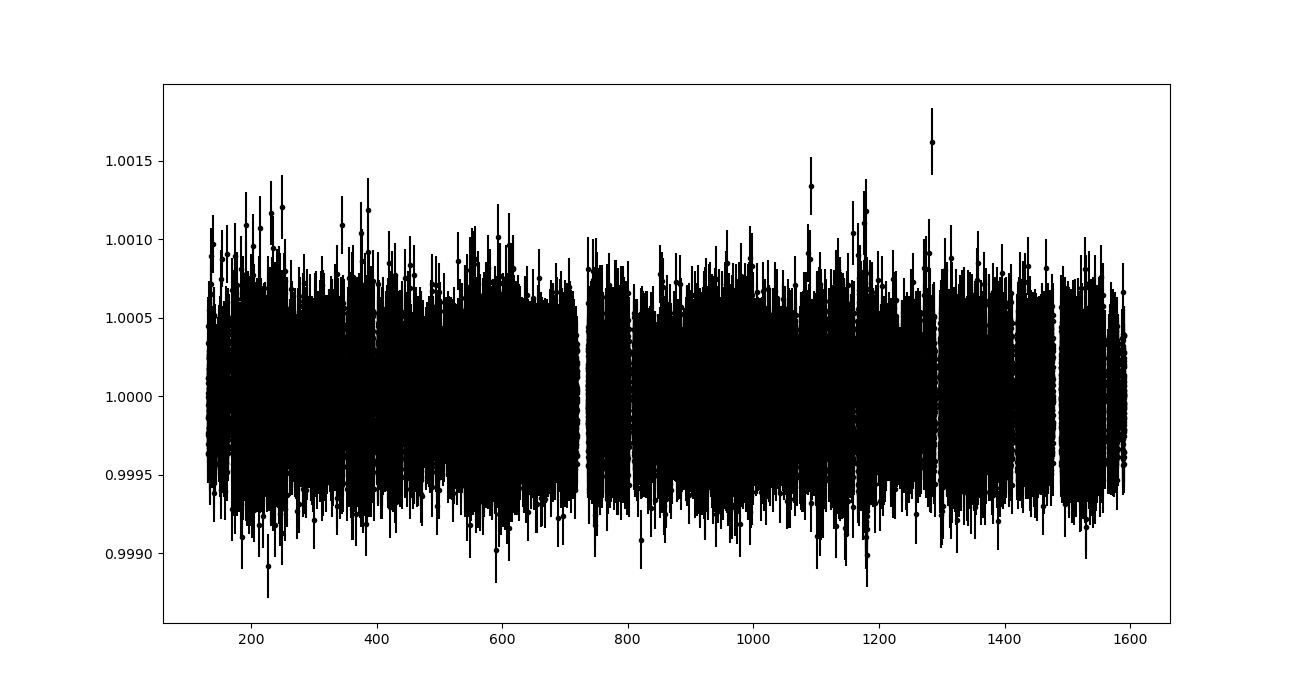

53036

In [12]:
plt.figure(figsize=(13,7))
plt.errorbar(data['lc_time'], data['lc_flux'], yerr=data['lc_flux_err'], fmt='.k')

len(data['lc_time'])

# Plot your data folded

<IPython.core.display.Javascript object>


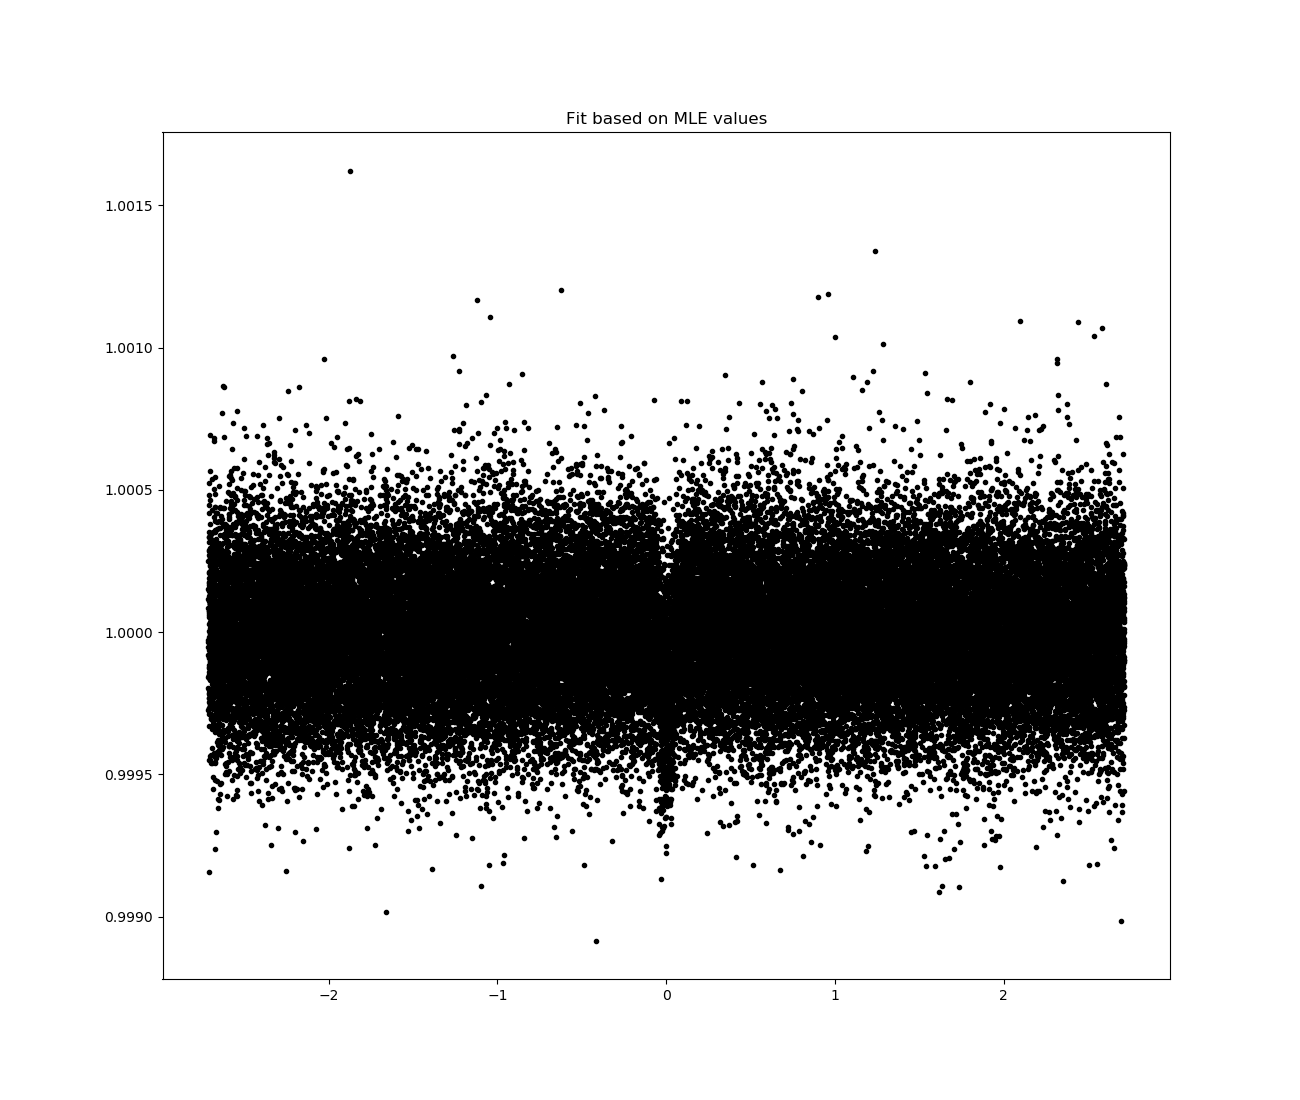

In [13]:
lc_t_fold = (data['lc_time'] - t0_pri_day + 0.5 * p_day) % p_day - 0.5 * p_day


plt.figure(figsize=(13,11))
plt.title('Fit based on MLE values')
plt.plot(lc_t_fold, data['lc_flux'], '.k')

# Create tranist masks

These will be used in the solving process. We speed up the solver drastically by only fitting on data points within and near to the transits

<IPython.core.display.Javascript object>


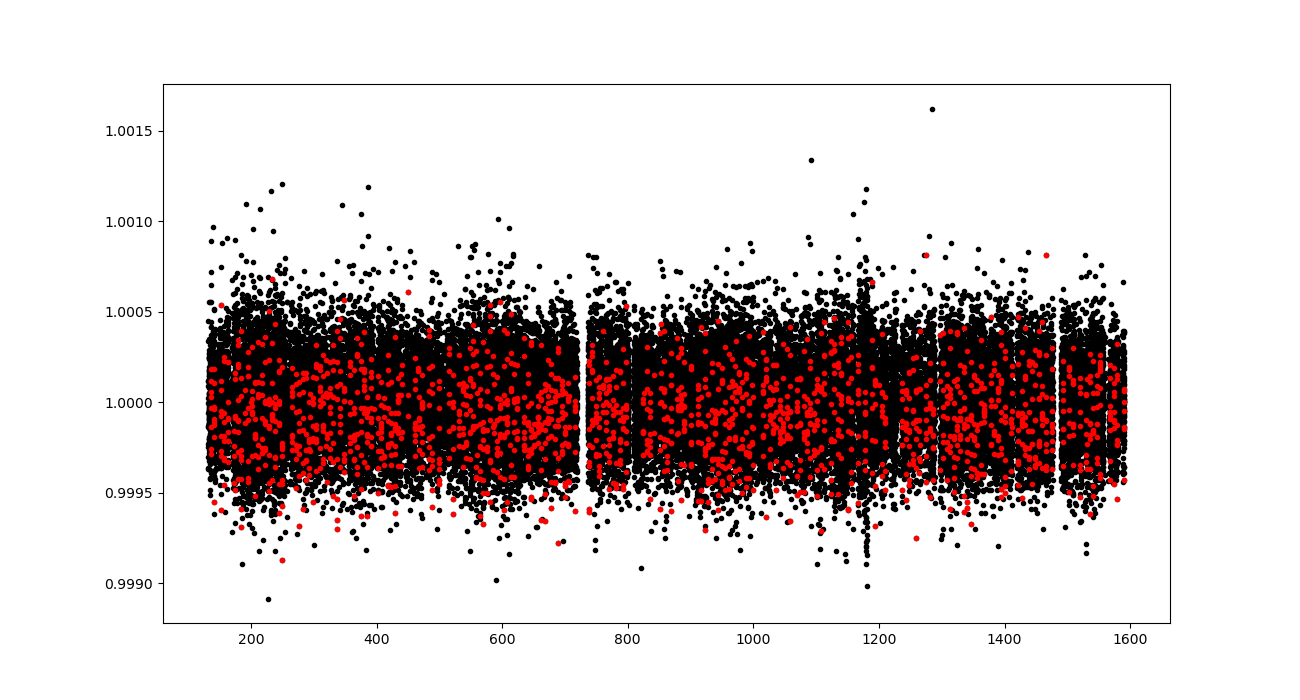

1877

In [14]:
transit_idx_p = mask_transits(t0_bkjd=float(t0_pri_day), 
                                period_day=float(p_day), 
                                duration_day=float(d_day) * 1.5, 
                                time_bkjd=data['lc_time'], 
                                flux=data['lc_flux'], 
                                lc=None, 
                                return_index=True)

if has_sec_eclipse:

    transit_idx_s = mask_transits(t0_bkjd=float(t0_sec_day), 
                                    period_day=float(p_day), 
                                    duration_day=float(d_day) * 1.5, 
                                    time_bkjd=data['lc_time'], 
                                    flux=data['lc_flux'], 
                                    lc=None, 
                                    return_index=True)

    transit_idx = transit_idx_p | transit_idx_s
    
else:
    
    transit_idx = transit_idx_p
    
    

plt.figure(figsize=(13,7))
plt.plot(data['lc_time'], data['lc_flux'], '.k')
plt.plot(data['lc_time'][transit_idx_p], data['lc_flux'][transit_idx_p], '.r')
if has_sec_eclipse:
    plt.plot(data['lc_time'][transit_idx_s], data['lc_flux'][transit_idx_s], '.g')

len(data['lc_time'][transit_idx])

# Provide initial guesses and known parameters of your target system

Each parameter has 7 different inputs:
* toggle - solve for this parameter?
* dist - distribution to use when solving via MCMC
* tex - TEX string formatting for pretty plots
* sv - starting value, your best guess at the actual value
* lb - lower bound, lowest value allowed. Not used when dist="normal".
* ub - upper bound, maximum value allowed. Not used when dist="normal".
* sd - standard deviation, used when dist="normal" is chosen. Values will be sampled from normal dist with mu=sv and sd=sd. Also used when choosing random initial guesses for the MCMC chains.


The parameter "use_a" should always be turned on. Otherwise, stellar mass and radius may be misrepresented in the model as solar mass radius.

I have produced better results when the parameter "use_b" is turned on.

Whenever you find that the eccentricity for your system is near to zero, you should enable "ecc_is_zero". Typically you dont know this beforehand, so you would solve once with ecc_is_zero=False and if it solved to an eccentricity < 0.01, then you should try to solve again with this turned on. This makes the solving job easier and makes the corner plot prettier.

Pay attention to the outputs of this cell, as I do bounds checks and if any of your bounds dont make sense you need to fix them! If you dont, you run a high risk of failure to solve.

In [15]:
use_a = 1 # If true, mass inputs are not considered and are automatically computed.

use_b = 1 # If true, solves for impact parameter (b) instead of orbital plane inclination (incl).

ecc_is_zero = 1 # If true, eccentricity is assumed zero (circular orbit) and 'ecc' & 'omega' params are not used.
    
if target_name == '8804845':
    
    params0 = {
              ################################################### Orbital Parameters ###################################################

              't0':   {'toggle': 1,    # t0 [day]
                       'dist':   'normal', 
                       'tex':   '$t_0$ [$\mathrm{day}$]', 
                       'sv':     t0_pri_day, 
                       'lb':     t0_pri_day - 1.0, 
                       'ub':     t0_pri_day + 1.0, 
                       'sd':     0.1},

              'p':    {'toggle': 1,    # period [day]
                       'dist':   'normal',  
                       'tex':   '$P$ [$\mathrm{day}$]', 
                       'sv':     p_day, 
                       'lb':     p_day - 0.1, 
                       'ub':     p_day + 0.1, 
                       'sd':     0.001},

              'ecc':  {'toggle': 1,     # eccentricity
                       'dist':   'uniform',  
                       'tex':   '$ecc$', 
                       'sv':     1.0e-5, 
                       'lb':     1e-7, 
                       'ub':     0.5, 
                       'sd':     0.001},

              'omega': {'toggle': 1,   # argument of peri (radians)
                       'dist':   'normal',  
                       'tex':   '$\omega$ [$\mathrm{rad}$]', 
                       'sv':     0.0, 
                       'lb':     -2 * np.pi, 
                       'ub':     2 * np.pi, 
                       'sd':     0.1},

              'b':    {'toggle': 1,    # impact param
                       'dist':   'uniform',  
                       'tex':   '$b$', 
                       'sv':     0.9, 
                       'lb':     0.0, 
                       'ub':     1.0, 
                       'sd':     0.16},

              'a':    {'toggle': 1,    # separation distance in unit R_sun
                       'dist':   'uniform',  
                       'tex':   '$a$ [$\mathrm{R_{\odot}}$]', 
                       'sv':     (0.06 / R_sun.to(u.AU)).value, 
                       'lb':     0.0, 
                       'ub':     1.0e10, 
                       'sd':     1.0},

              's':    {'toggle': 0,    # Surface brightness ratio [F2 / F1]
                       'dist':   'uniform',  
                       'tex':   '$S_{2}/S_{1}$',
                       'sv':     0.483, 
                       'lb':     0.0, 
                       'ub':     1.0, 
                       'sd':     0.1},

              'incl': {'toggle': 1,    # orbital plane inclination angle (radians)
                       'dist':   'uniform', 
                       'tex':   'incl [$\mathrm{rad}$]',
                       'sv':     90.0 * np.pi / 180, 
                       'lb':     80.4 * np.pi / 180, 
                       'ub':     94.4 * np.pi / 180, 
                       'sd':     0.1},

              ################################################### Limb Darkening Parameters ###################################################

              'u1a':  {'toggle': 1,    # primary Limb darkening quadratic param 1 - edge curvature 
                       'dist':   'uniform', 
                       'tex':   '$u_{1a}$',
                       'sv':     0.0, 
                       'lb':     -1.0, 
                       'ub':     2.0, 
                       'sd':     0.1},

              'u1b':  {'toggle': 1,    # primary Limb darkening quadratic param 2 - edge curvature 
                       'dist':   'uniform', 
                       'tex':   '$u_{1b}$', 
                       'sv':     1.957, 
                       'lb':     0.0, 
                       'ub':     2.0, 
                       'sd':     0.1},

              'u2a':  {'toggle': 1,    # companion Limb darkening quadratic param 1 - edge curvature 
                       'dist':   'uniform',  
                       'tex':   '$u_{2a}$',
                       'sv':     0.0, 
                       'lb':     -1.0, 
                       'ub':     2.0, 
                       'sd':     0.1},

              'u2b':  {'toggle': 1,    # companion Limb darkening quadratic param 2 - edge curvature 
                       'dist':   'uniform',  
                       'tex':   '$u_{2b}$',
                       'sv':     1.95, 
                       'lb':     0.0, 
                       'ub':     2.0, 
                       'sd':     0.1},

               ################################################### Stellar / Planetary Parameters ###################################################

              'r_ratio': {'toggle': 1, # radius ratio (R2 / R1) - depth of transit
                       'dist':   'uniform',  
                       'tex':   '$R_{2}/R_{1}$',
                       'sv':     0.0173, 
                       'lb':     0.0173 * 0.5, 
                       'ub':     0.0173 * 1.5, 
                       'sd':     0.0056},

              'R1':   {'toggle': 0,    # radius of primary star in solar units (M_sun)
                       'dist':   'uniform', 
                       'tex':   '$R_{1}$ [$R_\odot$]', 
                       'sv':     0.93, 
                       'lb':     0.7, 
                       'ub':     20, 
                       'sd':     0.1},

              'R2':   {'toggle': 0,    # radius of companion in solar units (M_sun)
                       'dist':   'uniform', 
                       'tex':   '$R_{2}$ [$R_\odot$]', 
                       'sv':     0.78 * R_earth / R_sun, 
                       'lb':     0.0001, 
                       'ub':     1.5, 
                       'sd':     0.1},

              'M1':   {'toggle': 0,    # mass of primary star in solar units (R_sun)
                       'dist':   'uniform', 
                       'tex':   '$M_{1}$ [$M_\odot$]', 
                       'sv':     0.939, 
                       'lb':     0.8, 
                       'ub':     1.2, 
                       'sd':     0.01},

              'M2':   {'toggle': 0,    # mass of companion in solar units (R_sun)
                       'dist':   'uniform', 
                       'tex':   '$M_{2}$ [$M_\odot$]', 
                       'sv':     0.283911, 
                       'lb':     0.01, 
                       'ub':     1.2, 
                       'sd':     0.001},

              ################################################### Light Cruve Parameters ###################################################

              'cont': {'toggle': 0,    # Continuum baseline level
                       'dist':   'uniform', 
                       'tex':   'Unity',
                       'sv':     1.0, 
                       'lb':     0.0, 
                       'ub':     1.5, 
                       'sd':     0.1},

              'lc_err': {'toggle': 0,  # Avg error of light curve data points
                       'dist':   'uniform', 
                       'tex':   '$F_{err}$',
                       'sv':     1.0e-5, 
                       'lb':     0.0, 
                       'ub':     0.01, 
                       'sd':     1e-7},
             }

    
##############################################################################################################################################################################################

# Convert param database to legacy format and check for bounds errors
toggle, sv, lb, ub, sd, dist = {},{},{},{},{},{}

for k in params0.keys():
    
    if (params0[k]['lb'] > params0[k]['ub']):
    
        print('ERROR:' + k + ' lower bound > upper bound. Program will fail!')
    
    elif (params0[k]['lb'] > params0[k]['sv']):
        
        print('ERROR:' + k + ' lower bound > starting value. Program will fail!')
        
    elif (params0[k]['ub'] < params0[k]['sv']):
        
        print('ERROR:' + k + ' upper bound < starting value. Program will fail!')
        
    else: # All checks passed, import variable to legacy format
        
        toggle[k] = params0[k]['toggle']
        sv[k] = params0[k]['sv']
        lb[k] = params0[k]['lb']
        ub[k] = params0[k]['ub']
        sd[k] = params0[k]['sd']
        dist[k] = params0[k]['dist']
    
    
if lb['ecc'] <= 0.0: # Program does not like when ecc is exactly zero. Wierd.
    
    lb['ecc'] = 1.0e-10
    
params = {'toggle': toggle, 
          'sv': sv, 
          'lb': lb, 
          'ub': ub, 
          'sd': sd,
          'dist': dist,
         }


params['toggle']['has_sec_eclipse'] = has_sec_eclipse
params['toggle']['use_a'] = use_a
params['toggle']['use_b'] = use_b
params['toggle']['ecc_is_zero'] = ecc_is_zero

# force param toggles based on initial options
if params['toggle']['ecc_is_zero']:
    
    params['toggle']['ecc'] = 0
    params['toggle']['omega'] = 0
    
if params['toggle']['use_a']:
    
    params['toggle']['M1'] = 0
    
if params['toggle']['use_b']:
    
    params['toggle']['incl'] = 0
    
if not has_sec_eclipse:
    
    params['toggle']['s'] = 0
    params['toggle']['u2a'] = 0
    params['toggle']['u2b'] = 0

params['toggle']['M2'] = 0 # Cant be solved without RVs (???)

# Some var distribution (theano tensors) need to be shape=1 instead of shape=0
shape_1_vars = np.array(['u1a', 'u1b', 'u2a', 'u2b', 'r_ratio', 'R1', 'R2', 'M1', 'M2']) #, 'a', 'b'

print('done')

done


# Do a test instantiation of the orbital model

Also allows us to plot a fit based on our starting guesses (sv)

In [16]:
model, map_soln, orbit, sim_lc = make_lc_rv_mcmc(data, params, optimize_q=0)

map_soln

{'t0': array([135.870397]),
 'p': array([5.425838]),
 'r_ratio_interval__': array([0.]),
 'u1a_interval__': array([-0.69314718]),
 'u1b_interval__': array([3.81796785]),
 'a_interval__': array([-20.46847407]),
 'b_interval__': array([2.19722458])}

# Plot the fit of our initial guesses

<IPython.core.display.Javascript object>


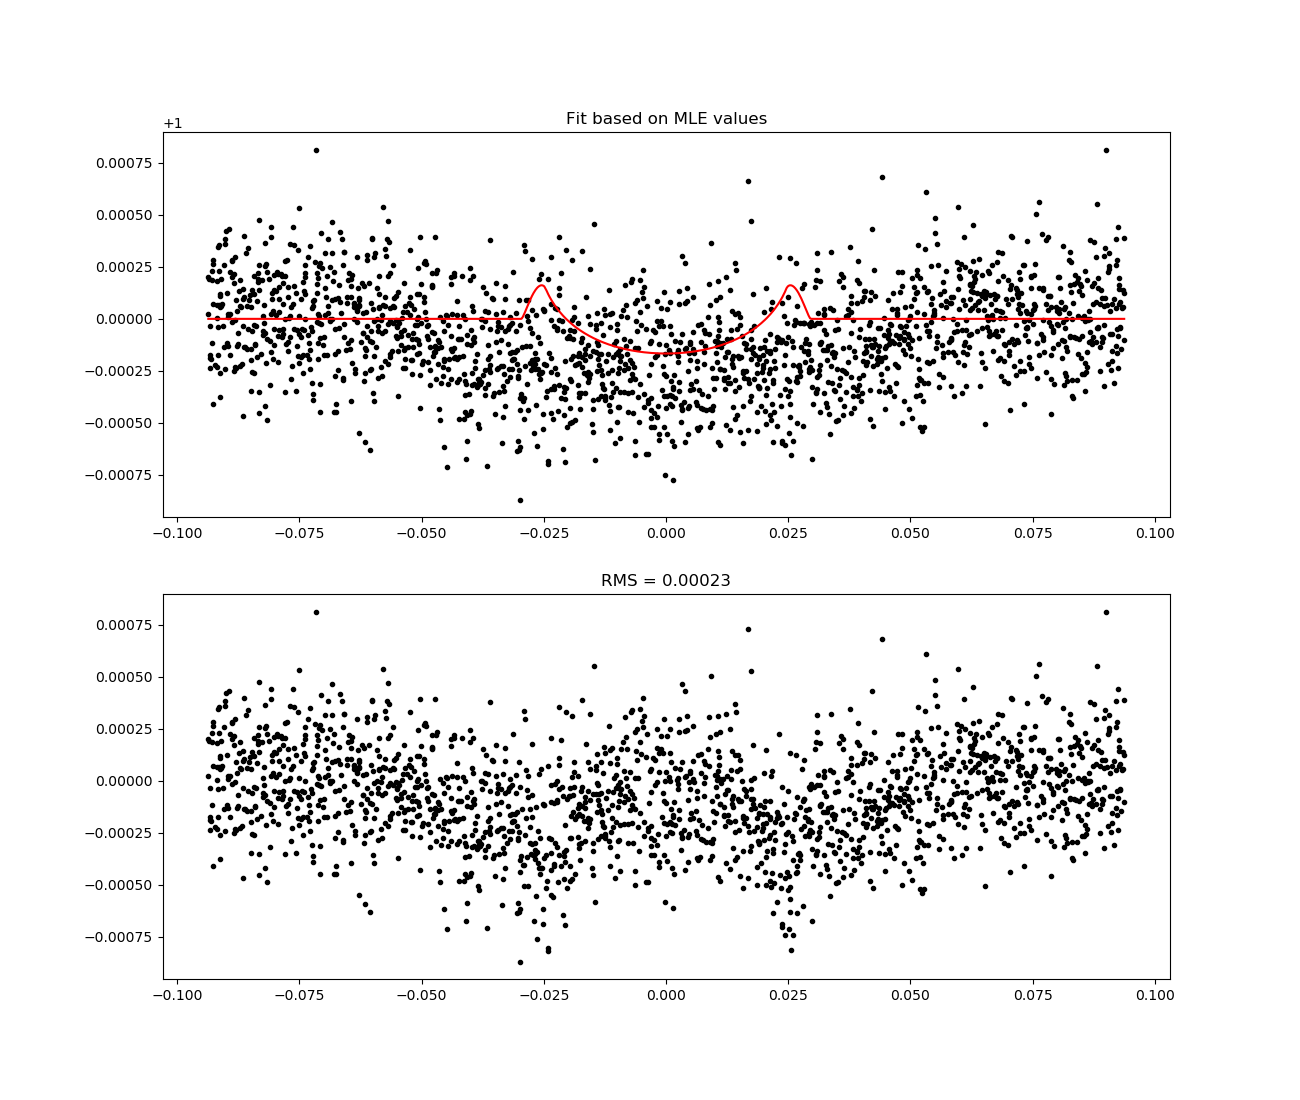

<IPython.core.display.Javascript object>


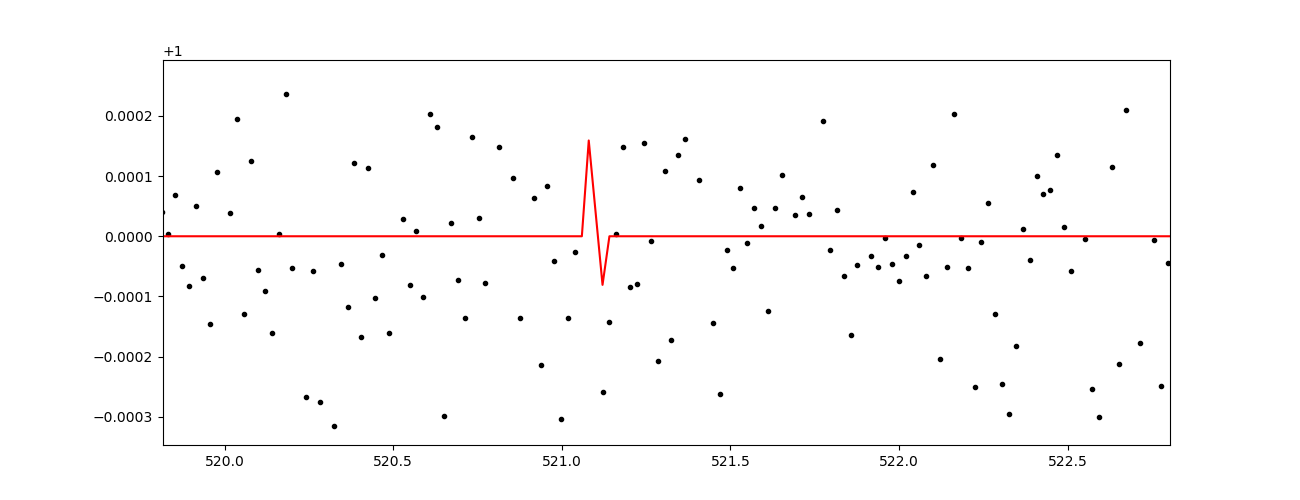

In [17]:
t0 = params['sv']['t0']
p = params['sv']['p']
    
plot_fits(t0, p, sim_lc)

# Reinitialize the model and pass it through optimizers

This code will try to optimize certian parameters one at a time, then at the end, optimize all of the prameters at once.

In [18]:
model, map_soln, orbit, sim_lc = make_lc_rv_mcmc(data, params)

map_soln

optimizing logp for variables: [t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 12815.31742550837 -> 12823.419159614265
optimizing logp for variables: [r_ratio]


message: Optimization terminated successfully.
logp: 12823.419159614272 -> 12823.871168106081
optimizing logp for variables: [u1b, u1a]


message: Desired error not necessarily achieved due to precision loss.
logp: 12823.871168106081 -> 13043.197752152917
optimizing logp for variables: [t0]


message: Optimization terminated successfully.
logp: 13043.197752152917 -> 13049.081935120326
optimizing logp for variables: [b, a, u1b, u1a, r_ratio, p, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: 13049.081935120326 -> 13187.081084871426


{'t0': array([135.86541402]),
 'p': array([5.42588068]),
 'r_ratio_interval__': array([-1.05356551]),
 'u1a_interval__': array([-0.1624833]),
 'u1b_interval__': array([-0.83746921]),
 'a_interval__': array([-20.38680384]),
 'b_interval__': array([-0.1635749]),
 'r_ratio': array([0.01312276]),
 'u1a': array([0.37840493]),
 'u1b': array([0.60413613]),
 'a': array([13.9998566]),
 'b': array([0.45919721]),
 'R2': array([0.01220417]),
 'incl': array([1.54028747]),
 'light_curves': array([[ 0.        ],
        [ 0.        ],
        [-0.00015237],
        ...,
        [-0.00020326],
        [ 0.        ],
        [ 0.        ]])}

# Plot the fit of the optimized params

<IPython.core.display.Javascript object>


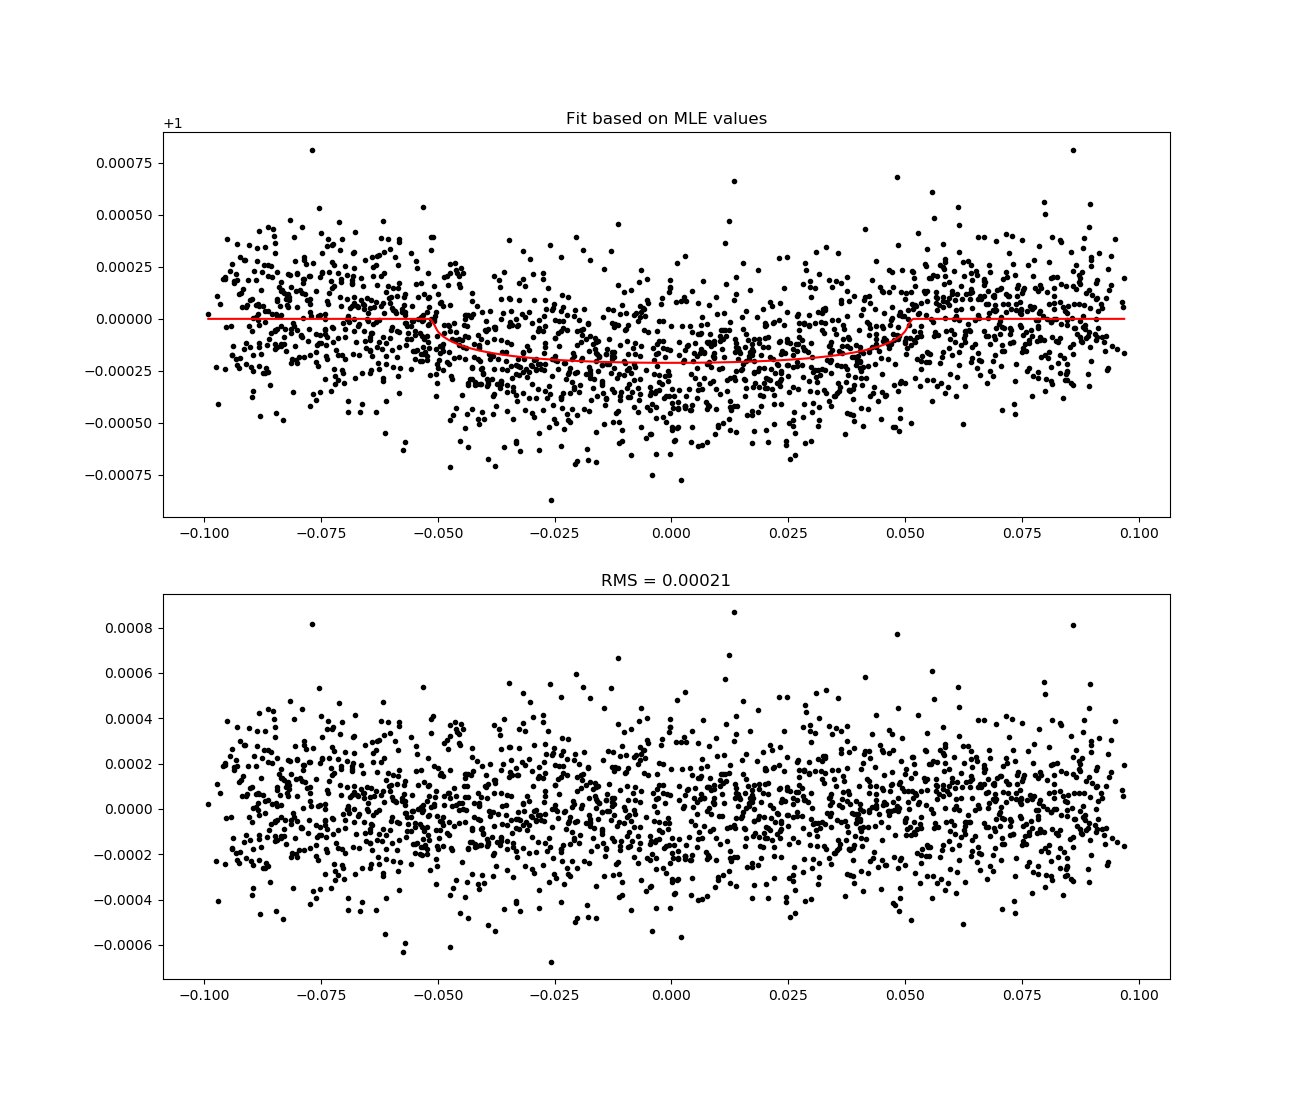

<IPython.core.display.Javascript object>


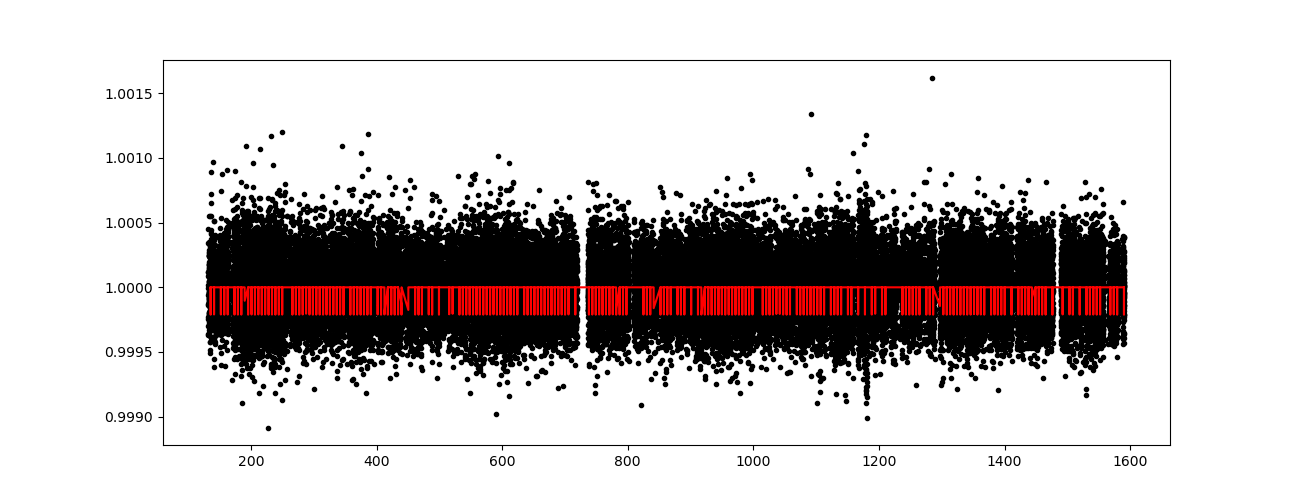

In [19]:
t0 = map_soln['t0']
p = map_soln['p']

plot_fits(t0, p, np.ravel(map_soln["light_curves"]) + 1)

# Process the orbit with MCMC

If you get bad results or an ugly corner plot after running this, it could be because of one of the following reasons:

* Not enough draws
* Starting guesses were not good enough
* Boundary conditions too tight or too loose
* If eccentricity was close to zero, then the omega parameter might be degenerate. If this is the case, set ecc_is_zero=False and rerun

The "draws" parameter is very important for several reasons. It determines 
* how long your program will take to run
* how accurate your results will be (kinda)
* how pretty your corner plot will be (sometimes)

In general, to few draws will not allow the solvers to converge onto a solution and then sample values ner the solution to estimate error. To many draws could mean your program will run for days and you may even crash the notebook and lose all of your progress. Both of these concepts are situation dependent, but can mostly be estimated based on two things; how much data will be fit and how difficult the fit is to solve.


Here is an estimation formula how many draws to allow:

draws = difficulty * data_length

, where difficulty is in the range [1, 2, 3] and data_length = len(data['lc_time'][transit_idx])

For those of you fititng hard to find tranists found in your ML models, your difficulty is likely a 3.


## Tunable params:
* tune - familiarize the MCMC algo with your problem, the more, the better, but more than 1000 is probably too much
* draws - described above
* chains - how many solvers will run in parallel trying to solve your problem
* cores - how many CPU cores will be used. Does not seem to increase speed much, but it might. Do not use more than 10, since others are using this PC.

In [20]:
print('started')

import pymc3_ext as pmx
    
with model:

    trace = pmx.sample(tune=250, draws=1000, start=map_soln, chains=4, cores=10)
    
print('done')

started


Multiprocess sampling (4 chains in 10 jobs)
NUTS: [b, a, u1b, u1a, r_ratio, p, t0]


Sampling 4 chains for 250 tune and 1_000 draw iterations (1_000 + 4_000 draws total) took 438 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


done


# Get a list of variables that were used in the MCMC solver

In [27]:
# Show plottable params

plottable_params = []
for k in trace.varnames:
    
    if (k.find('_interval') == -1) & (k.find('light_c') == -1):
        
        plottable_params.append(k)
        
plottable_params = np.array(plottable_params)
        
for k in np.sort(plottable_params):
    
    print(k)

R2
a
b
incl
p
r_ratio
t0
u1a
u1b


# Extract the statistical results from the solver output


### Tunable params
* omit_early_sample_cnt - Its sometimes good to omit some of the early iterations of the solver from your results since the solver may have not converged on the solution yet.
* convert_incl_to_deg - show radians or degrees in your plots?
* plot_var_include - these are the variables that will be shown in the corner plot and the first pretty text plot below. These MUST be parameters that were actually solved for, otherwise you will get an error.

In [37]:
omit_early_sample_cnt = 500 # how many samples to omit from MLE result calulations and plots
convert_incl_to_deg = 1

plot_var_include = np.array(['p', 't0', 'a', 'incl', 'ecc', 'omega', 's', 'r_ratio']) # Solved vars to view in corner plot and pretty text plot
    
if ecc_is_zero:
    
    plot_var_include = np.setdiff1d(plot_var_include, np.array(['ecc', 'omega']))
    
if not has_sec_eclipse:
    
    plot_var_include = np.setdiff1d(plot_var_include, np.array(['s']))

pvi = np.zeros(len(plot_var_include), dtype=int)
labels = []
labels_tex = []
for ki, k in enumerate(plottable_params):
    
    if np.any(k == plot_var_include):
        
        pvi[k == plot_var_include] = ki
        

    labels.append(k)
    labels_tex.append(params0[k]['tex'])

labels = np.array(labels)
labels_tex = np.array(labels_tex)

flat_samples = np.copy(pm.trace_to_dataframe(trace[omit_early_sample_cnt:], varnames=labels).to_numpy())

if convert_incl_to_deg:
    incl_idx = plottable_params == 'incl'
    flat_samples[:, incl_idx] = flat_samples[:, incl_idx] / np.pi * 180
    labels_tex[incl_idx] = '$incl$ [$\mathrm{deg}$]'

fv = np.zeros((len(labels), 3), dtype=float)

for i in range(len(labels)):
    
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        
    q = np.diff(mcmc)
    
    fv[i, 0] = mcmc[1]
    fv[i, 1] = q[0]
    fv[i, 2] = q[1]

# Plot the median LC fit from the MCMC process

If you see weird issues with your fit, you can enable use_opti_t0_p and see if that cleans it up. If not, and your corner plot does not look normal, then you probably did not converge to a good solution.

<IPython.core.display.Javascript object>


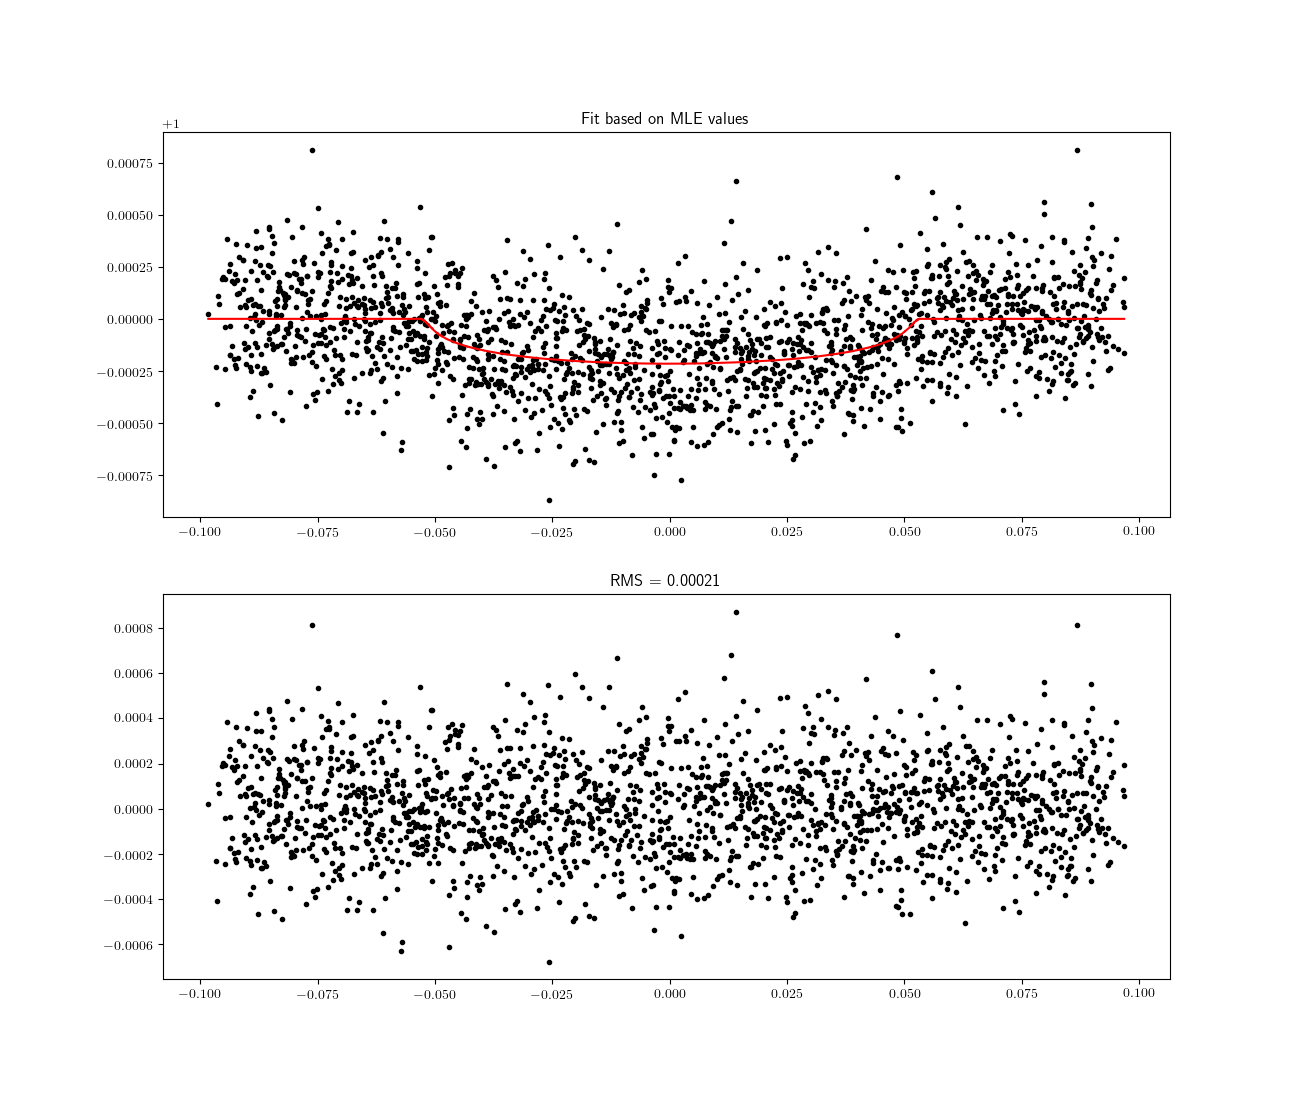

<IPython.core.display.Javascript object>


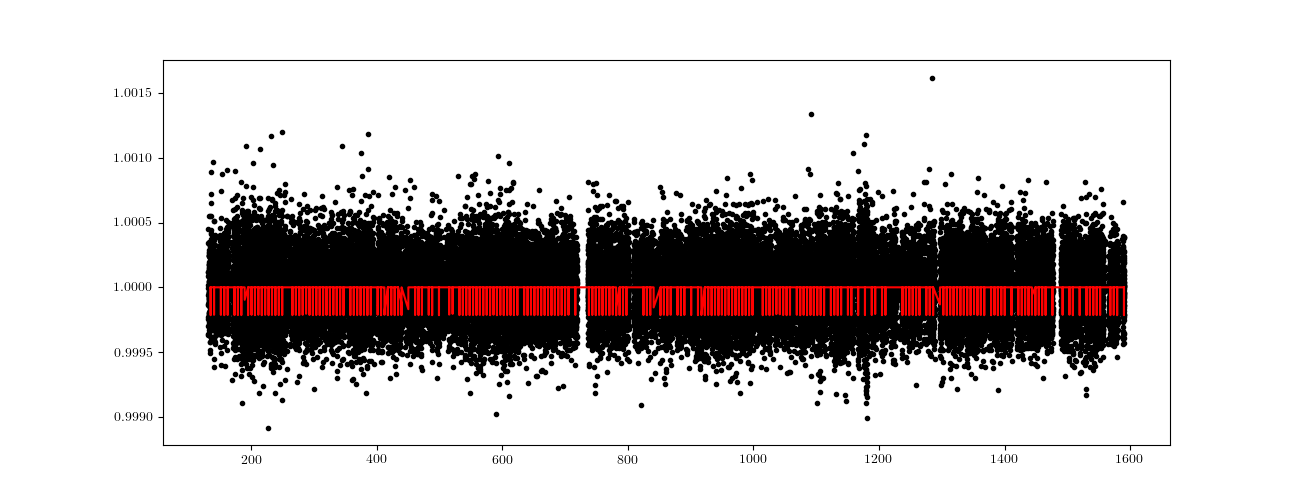

In [44]:
use_opti_t0_p = 0 # Use the LSE (True) or MLE(False) t0 and period values

# Get all lightcurve fits tried in MCMC
trace_lcs = np.copy(pm.trace_to_dataframe(trace[omit_early_sample_cnt:], varnames=['light_curves']))

# Find meadian of all LCs
mle_lc = np.nanmedian(trace_lcs, axis=0)

if use_opti_t0_p:
    t0 = map_soln['t0']
    p = map_soln['p']
else:
    t0 = fv[labels == 't0', 0]
    p = fv[labels == 'p', 0]

plot_fits(t0, p, mle_lc + 1)

# Create a corner plot of your MCMC process

<IPython.core.display.Javascript object>


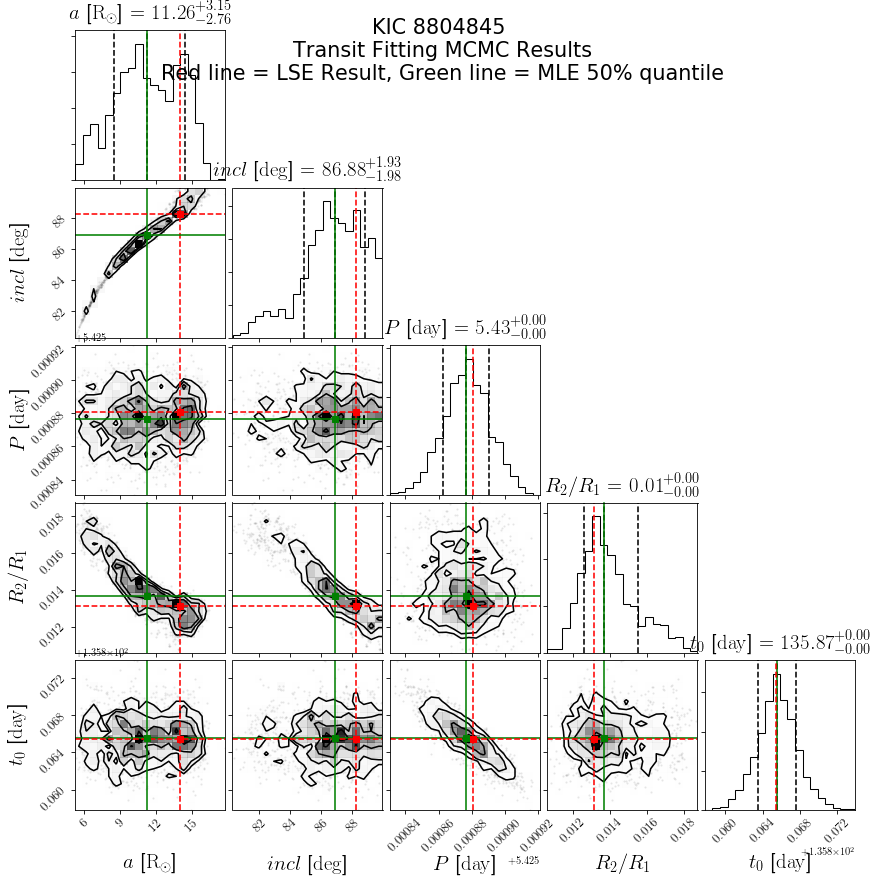

In [43]:
show_lse_mle_res_lines = 1 # will overplot LSE results for comparison

if ecc_is_zero:
    main_title_fontsize = 20
    plot_img_dpi = 75 # controls how large plot is
else:
    main_title_fontsize = 27
    plot_img_dpi = 70 # controls how large plot is
subplot_title_fontsize = 20
axes_label_fontsize = 20
axes_ticks_fontsize = axes_label_fontsize * 0.63


###############################################################################################
# Make corner plot
            
import corner
            
fig = corner.corner(flat_samples[:, pvi], 
                    labels=labels_tex[pvi], 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    #fig=fig,
                    title_kwargs={"fontsize": subplot_title_fontsize}, 
                    label_kwargs={"fontsize": axes_label_fontsize}
                   );

fig.set_dpi(plot_img_dpi)

###############################################################################################
# Add LSE and MLE results to the subplots

if show_lse_mle_res_lines:
    
    # MLE avg
    value1 = fv[pvi, 0]

    # LSE results
    value2 = np.array([map_soln[label] for label in labels])
    value2[incl_idx] = value2[incl_idx] / np.pi * 180
    value2 = value2[pvi]

    # Extract the axes
    ndim = len(pvi)

    axes = np.array(fig.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        
        ax.axvline(value1[i], color="g")
        ax.axvline(value2[i], color="r", ls='--')
            
        ax.tick_params(labelsize=axes_ticks_fontsize)

    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color="g")
            ax.axvline(value2[xi], color="r", ls='--')
            ax.axhline(value1[yi], color="g")
            ax.axhline(value2[yi], color="r", ls='--')
            ax.plot(value1[xi], value1[yi], "sg")
            ax.plot(value2[xi], value2[yi], "sr")

            ax.tick_params(labelsize=axes_ticks_fontsize)

    lse_mle_title_append = '\nRed line = LSE Result, Green line = MLE 50% quantile'
    
else:
    
    lse_mle_title_append = ''

plt.suptitle('KIC ' + target_name + 
             ' \nTransit Fitting MCMC Results' + 
             lse_mle_title_append, 
             usetex=False, fontsize=main_title_fontsize);


# Make a pretty text plot of your SELECTED (plot_var_include) solved params

This is good for your presentations and just having a nice representation of your solved parameters

<IPython.core.display.Javascript object>


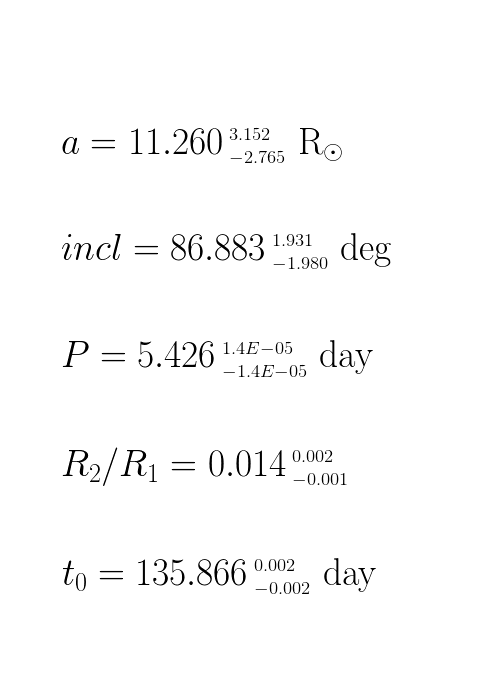

(0, 0.0175)

In [40]:
from decimal import Decimal

fig = plt.figure(np.random.randint(0, 1000), figsize=(5,7))
ax = plt.subplot(1,1,1, frame_on=False)

from matplotlib import rc
plt.rc('text', usetex=True)

for i in range(len(pvi)):
    
    ir = pvi[len(pvi) - 1 - i]
    
    lab = str(np.copy(labels_tex[ir]))
    unit = ''
    
    if lab.find('[') > 0:
        
        unit = ' ' + lab[lab.find('[') + 1 :-1]
        unit = unit.replace('{', '{{')
        unit = unit.replace('}', '}}')
        
        lab = lab[:lab.find('[')]
        
    lab = lab.replace(r'$', '')
    
    if (fv[ir, 1] > 1e-3) & (fv[ir, 2] > 1e-3):
        txt = "${3} = {0:.3f}_{{\:\scriptscriptstyle-{1:.3f}}}^{{\:\scriptscriptstyle{2:.3f}}}$ " + unit
        txt = txt.format(fv[ir, 0], fv[ir, 1], fv[ir, 2], lab)
    else:
        txt = "${3} = {0:.3f}_{{\:\scriptscriptstyle-{1:.1E}}}^{{\:\scriptscriptstyle{2:.1E}}}$ " + unit
        txt = txt.format(fv[ir, 0], fv[ir, 1], fv[ir, 2], lab)
    
    ax.text(0.0, 0.001 + i * 0.0035, txt, fontsize=27)

ax.axis('tight')
ax.axis('off')

plt.xlim(0, 0.015)
plt.ylim(0, i * 0.0035 + 0.0035)

# os.makedirs(fig_save_dir, exist_ok=1)

# plt_fn = plateName + '_' + str(beamNum_odd) + '_solved_orbital_params.png'

# fig.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)

# Make a pretty text plot of your solved & known orbital params

This is good for your presentations and just having a nice representation of your solved parameters

<IPython.core.display.Javascript object>


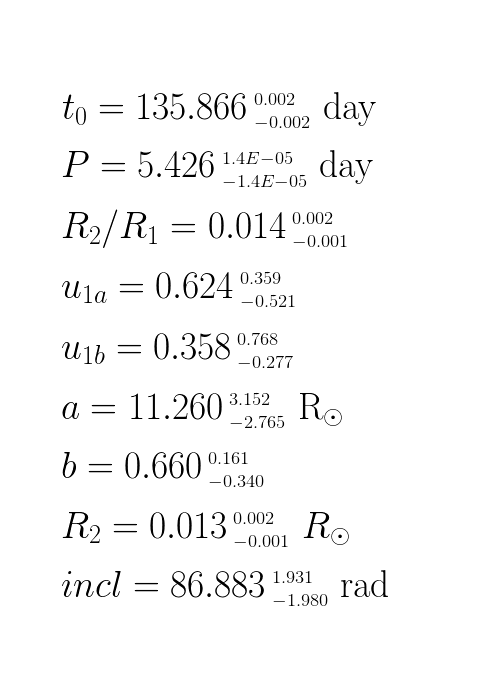

(0, 0.0315)

In [42]:
from decimal import Decimal

pvi2 = np.zeros(len(plottable_params), dtype=int)
labels2 = []
labels_tex2 = []
for ki, k in enumerate(plottable_params):
    
    pvi2[ki] = ki
        

    labels2.append(k)
    labels_tex2.append(params0[k]['tex'])

labels2 = np.array(labels2)
labels_tex2 = np.array(labels_tex2)

fig = plt.figure(np.random.randint(0, 1000), figsize=(5,7))
ax = plt.subplot(1,1,1, frame_on=False)

from matplotlib import rc
plt.rc('text', usetex=True)

for i in range(len(pvi2)):
    
    ir = pvi2[len(pvi2) - 1 - i]
    
    lab = str(np.copy(labels_tex2[ir]))
    unit = ''
    
    if lab.find('[') > 0:
        
        unit = ' ' + lab[lab.find('[') + 1 :-1]
        unit = unit.replace('{', '{{')
        unit = unit.replace('}', '}}')
        
        lab = lab[:lab.find('[')]
        
    lab = lab.replace(r'$', '')
    
    if (fv[ir, 1] > 1e-3) & (fv[ir, 2] > 1e-3):
        txt = "${3} = {0:.3f}_{{\:\scriptscriptstyle-{1:.3f}}}^{{\:\scriptscriptstyle{2:.3f}}}$ " + unit
        txt = txt.format(fv[ir, 0], fv[ir, 1], fv[ir, 2], lab)
    else:
        txt = "${3} = {0:.3f}_{{\:\scriptscriptstyle-{1:.1E}}}^{{\:\scriptscriptstyle{2:.1E}}}$ " + unit
        txt = txt.format(fv[ir, 0], fv[ir, 1], fv[ir, 2], lab)
    
    ax.text(0.0, 0.001 + i * 0.0035, txt, fontsize=27)

ax.axis('tight')
ax.axis('off')

plt.xlim(0, 0.015)
plt.ylim(0, i * 0.0035 + 0.0035)

# os.makedirs(fig_save_dir, exist_ok=1)

# plt_fn = plateName + '_' + str(beamNum_odd) + '_solved_orbital_params.png'

# fig.savefig(os.path.join(fig_save_dir, plt_fn), dpi=None)